In [1]:
%%capture
pip install -r ../../requirements.txt

In [2]:
# Install the required packages
import sys 
import requests #needed to perform HTTP GET and POST requests
import numpy as np
import pandas as pd

# NLP
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Need this set to None otherwise text columns will truncate!
pd.set_option('display.max_colwidth', None) 

/Users/chrismcallister/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# set this on the path so that we can reference the commong data locations
sys.path.append("../../scripts/")
from process_text_data import text_embeddings, compute_similarity_scores

In [4]:
text_data = pd.read_csv('../../data/posts.csv')

In [6]:
def calc_cosine_similarities(dataset, model_list, pos_query, neg_query, column_of_text = 'text'):

    # Initialize output df, which initially is the same as the input one. 
    output_data = dataset.copy()

    # Specify which column should be encoded
    text_to_encode = dataset[column_of_text]
    text_to_encode = dataset[column_of_text].fillna(dataset[column_of_text])

    # Iterate over each model, encode the queries
    for model in model_list:

        print('started with model: ' + model)
    
        # Load in the model
        load_model = SentenceTransformer(model, device="cpu") 
    
        # Encode the positive post
        pos_embedding = load_model.encode(pos_query)
    
        # Encode the negative post
        neg_embedding = load_model.encode(neg_query)
        
        pos_sim_list = []
        neg_sim_list = []
        
        # Iterate over each post for that model, and calculate each post's cosine sim score to each query's embedding
        for post in text_to_encode:
    
            # Encode the post with chosen model
            embeddings = load_model.encode(post)
            
            # Compute similarity of positive / negative queries to the post:
            pos_sim_score = np.dot(pos_embedding, embeddings) / (np.linalg.norm(pos_embedding) * np.linalg.norm(embeddings))
            neg_sim_score = np.dot(neg_embedding, embeddings) / (np.linalg.norm(neg_embedding) * np.linalg.norm(embeddings))
            
            neg_similarities = cosine_similarity(embeddings.reshape(1, -1), neg_embedding.reshape(1, -1))
    
            # Append each post's similarity to the list
            pos_sim_list.append(pos_sim_score)
            neg_sim_list.append(neg_sim_score)
            
    
        # Once done for all posts, save scores to output df, under that model's name
        output_data[model + '_positive'] = pos_sim_list
        output_data[model + '_negative'] = neg_sim_list
    
        # Free memory after each model. Got a runtime error without this. 
        del load_model

        return output_data
        print("Done with " + model)


## Inputs to function

# Embed the query and compute similarity scores
negative_query = "Terrible experience with this company, never using them again."
positive_query = "I've had a fantastic experience with this company."  

data = text_data.copy()

# Models to try. Based off hugging face leaderboard: https://huggingface.co/spaces/mteb/leaderboard
model_names = ["multi-qa-mpnet-base-dot-v1", "thenlper/gte-large", "BAAI/bge-m3", "intfloat/multilingual-e5-small"]
## End Inputs

calc_cosine_similarities(data, model_names, positive_query, negative_query)

Done with multi-qa-mpnet-base-dot-v1
Done with thenlper/gte-large
Done with BAAI/bge-m3
Done with intfloat/multilingual-e5-small


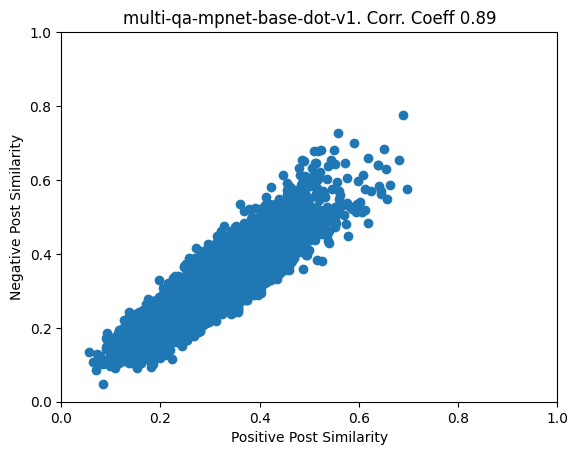

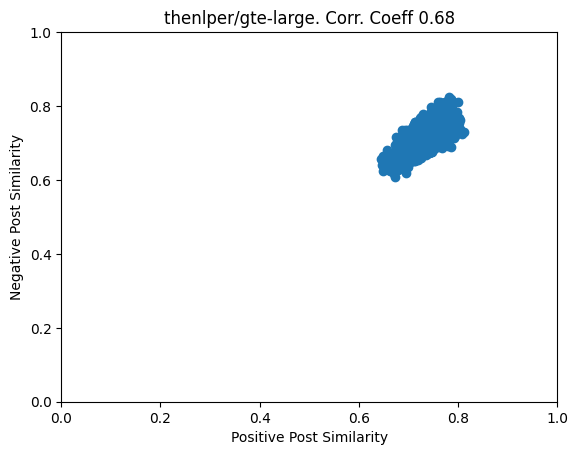

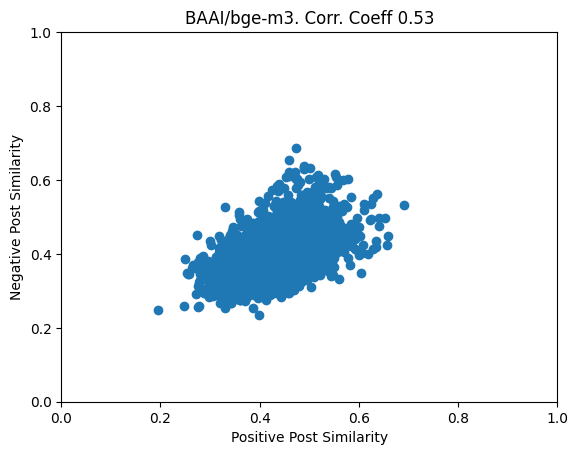

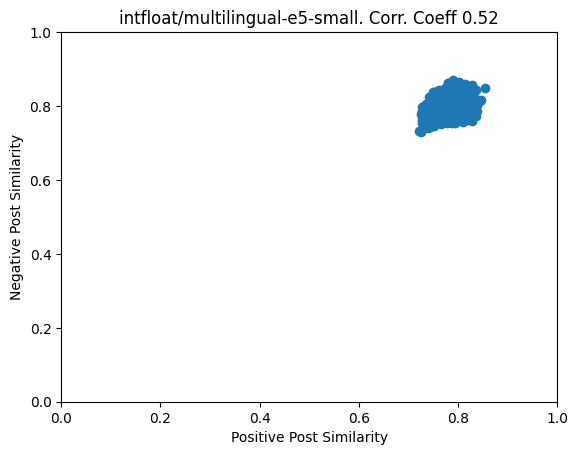

In [8]:
import matplotlib.pyplot as plt
for model in model_names:
    plt.scatter(data[model + '_positive'], data[model + '_negative'])
    
    correlation_coef = data[model + '_positive'].corr(data[model + '_negative'])
    
    plt.title(model + '. Corr. Coeff ' + str(round(correlation_coef, 2)))

    # Set the x-axis range
    plt.xlim(0, 1)
    plt.xlabel('Positive Post Similarity')

    plt.ylim(0, 1)
    plt.ylabel('Negative Post Similarity')
    plt.show()

In [11]:
# Save cosine similarity dataset to drive

import sys

# set this on the path so that we can reference the commong data locations
sys.path.append("../../scripts/")
from data_collection import authenticate_google_drive, save_google_drive_data

data_cosine_similarity = data.copy()
data_cosine_similarity['positive_query'] = pos_query
data_cosine_similarity['negative_query'] = neg_query

In [17]:
# Grab the Google Drive object
drive = authenticate_google_drive('../0_data_collection/credentials/google_drive_client_secret.json')

# # Save the data in the Google Drive location
save_google_drive_data(drive=drive, 
                       credential_file="../0_data_collection/credentials/google_drive_folder_id.json",  
                       dataframe =data_cosine_similarity, 
                       filename="cosine_similarity_scores.csv")

File 'cosine_similarity_scores.csv' uploaded successfully to folder 1kJ6TrI9MVT5mfnnYvS-OpRMJFVbIQ6Tl!


In [97]:
def create_embedding_dataframes(post_dataset, model_list, col_to_encode='text'):

    dataset = post_dataset.copy().reset_index()
    
    # Specify which text columns should be encoded.
    text_to_encode = post_dataset[col_to_encode].fillna("").astype(str)
    
    dfs = []

    # Iterate over models
    for model in model_list:
    
        print('Started with model ' + model)
    
        # Load in the model
        load_model = SentenceTransformer(model, device="cpu") 

        # text_to_encode = post_dataset[col_to_encode].fillna(post_dataset[col_to_encode])
    
        # Embed th posts
        post_embedding = load_model.encode(text_to_encode.values)
    
        # Store embeddings with that data's info
        data_with_embdedding = pd.concat([dataset, pd.DataFrame(post_embedding)], axis = 1)
    
        # Save embeddings as list of dfs
        dfs.append(data_with_embdedding)   

        print('Done with model: ' + model)

    return dfs

 
# Models to try. Based off hugging face leaderboard: https://huggingface.co/spaces/mteb/leaderboard
model_names = ["multi-qa-mpnet-base-dot-v1", "thenlper/gte-large", "BAAI/bge-m3", "intfloat/multilingual-e5-small"]
data = text_data.copy()

embedded_dfs = create_embedding_dataframes(text_data, model_names)

Started with model multi-qa-mpnet-base-dot-v1
Done with model: multi-qa-mpnet-base-dot-v1
Started with model thenlper/gte-large
Done with model: thenlper/gte-large
Started with model BAAI/bge-m3
Done with model: BAAI/bge-m3
Started with model intfloat/multilingual-e5-small
Done with model: intfloat/multilingual-e5-small


In [98]:
# Save each model's embeddings to drive here:

# Grab the Google Drive object
drive = authenticate_google_drive('../0_data_collection/credentials/google_drive_client_secret.json')
model_file_names = ["multi-qa-mpnet-base-dot-v1", "gte-large", "bge-m3", "multilingual-e5-small"]

for i, k in zip(model_file_names, embedded_dfs):
    
    dataset_name = 'data_encoded_'+i

    
    
    # # Save the data in the Google Drive location
    save_google_drive_data(drive=drive, 
                           credential_file="../0_data_collection/credentials/google_drive_folder_id.json",  
                           dataframe =data_cosine_similarity, 
                           filename=dataset_name)

File 'data_encoded_multi-qa-mpnet-base-dot-v1' uploaded successfully to folder 1kJ6TrI9MVT5mfnnYvS-OpRMJFVbIQ6Tl!
File 'data_encoded_gte-large' uploaded successfully to folder 1kJ6TrI9MVT5mfnnYvS-OpRMJFVbIQ6Tl!
File 'data_encoded_bge-m3' uploaded successfully to folder 1kJ6TrI9MVT5mfnnYvS-OpRMJFVbIQ6Tl!
File 'data_encoded_multilingual-e5-small' uploaded successfully to folder 1kJ6TrI9MVT5mfnnYvS-OpRMJFVbIQ6Tl!
